In [1]:
# 库文件导入 
import pyrealsense2 as rs  #D435I库
import numpy as np
import cv2
import os
import matplotlib.pyplot as plt
import time

In [2]:

# 配置深度和彩色数据流
start = time.time()              #记录程序运行起始时间
pipeline = rs.pipeline()         #定义通道变量，简化缩写
config = rs.config()             #数据流配置简写，允许管道用户为管道流以及设备选择和配置请求过滤器
#config.enable_all_streams()     #显示启用所有设备流
IMG_LIST=[[640,480],[1280,720]]  #[0]（640 X 480）  [1](1280 x 720)
IMG_WIDTH = IMG_LIST[1][0]     #图片的宽度   #常用800以下，便于深度学习训练（640 X 480）(1280 x 720)
IMG_HEIGHT = IMG_LIST[1][1]    #图片的高度 
config.enable_stream(rs.stream.depth, IMG_WIDTH, IMG_HEIGHT, rs.format.z16, 30)   #显示启用深度流，30是帧率
config.enable_stream(rs.stream.color, IMG_WIDTH, IMG_HEIGHT, rs.format.bgr8, 30)  #显示启用彩色流
config.enable_stream(rs.stream.infrared, 1, IMG_WIDTH, IMG_HEIGHT, rs.format.y8, 30) #显示启用红外流1
config.enable_stream(rs.stream.infrared, 2, IMG_WIDTH, IMG_HEIGHT, rs.format.y8, 30) #显示启用红外流1
#开始采集
profile = pipeline.start(config)
cv2.waitKey(5000)     # 等待时间(ms) = 获取图像，realsense刚启动的时候图像会有一些失真
# 深度图像向彩色对齐
align_to_color = rs.align(rs.stream.color)#简化缩写

#===深度像素单位 与 分割距离定义===#
# Getting the depth sensor's depth scale (see rs-align example for explanation)
depth_sensor =  profile.get_device().first_depth_sensor() 
depth_scale  =  depth_sensor.get_depth_scale() 
# print("Depth Scale is: " ,  depth_scale) 

# We will be removing the background of objects more than
# clipping_distance_in_meters meters away
clipping_distance_in_meters = 1       #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale

In [3]:
#===获得文件最大序号值===#
def Get_IMG_SeqNum(root = './', img_suffix = '.png', img_name_start = 'color', img_name_startnum = 5): 
    # root = './'  #指定目录 
    Seq_num_Png = [] 
    for files in os.listdir(root): 
        if (os.path.splitext(files)[1]== img_suffix) & (os.path.splitext(files)[0][:img_name_startnum]==img_name_start):  
            Seq_num_Png.append(int(os.path.splitext(files)[0][-6:])) 
    if len(Seq_num_Png)==0:  #列表为空 返回0  
        Seq_num_Png.append(0) 
    return max(Seq_num_Png)  

In [4]:
###===深度图像黑洞处理===###
class Class_deep_frame_hole_filling():
    def __init__(self):
        ###===过滤器===###
        #抽取过滤器   
        self.decimation = rs.decimation_filter()  
        self.decimation.set_option(rs.option.filter_magnitude, 1)   # 设置过滤幅值1   #原值 4 
        #空间过滤器    
        self.spatial = rs.spatial_filter()
        self.spatial.set_option(rs.option.filter_magnitude, 5)
        self.spatial.set_option(rs.option.filter_smooth_alpha, 1)
        self.spatial.set_option(rs.option.filter_smooth_delta, 50)
        self.spatial.set_option(rs.option.holes_fill, 3)
        #时间过滤器
        self.temporal = rs.temporal_filter()
        #孔填充过滤器
        self.hole_filling = rs.hole_filling_filter() 
        # Putting Everything Together
        # These filters work best when applied sequentially one after another.
        self.depth_to_disparity = rs.disparity_transform(True)  
        self.disparity_to_depth = rs.disparity_transform(False) 

    def all_filters_deal(self, frame_in):
        ###===处理过程===###
        frame = self.decimation.process(frame_in)  #抽取过滤器 
        frame = self.depth_to_disparity.process(frame)   #视差转换
        frame = self.spatial.process(frame)   #空间过滤器
        frame = self.temporal.process(frame)     #时间过滤器
        frame = self.disparity_to_depth.process(frame)   #视差转换
        frame_out = self.hole_filling.process(frame)    #孔洞填充
        return frame_out

In [5]:
#===检查文件序号值===#
# 定义要创建的目录
Image_path = ["./Image_NPY/NPY_color_depth/", "./Image_NPY/NPY_Infrared/", "./Image_NPY/NPY_depthFill/", 
            "./Image_IMG/IMG_color_depth/", "./Image_IMG/IMG_Infrared/", "./Image_IMG/IMG_depthFill/"]   

def Check_IMG_SeqNum(root = ['./','./'],img_suffix = '.npy', img_name_start =['color','depth','depthFill'], img_name_startnum = 5):
    # root = './'  #指定目录
    Seq_num_Color = []
    Seq_num_Depth = []
    Seq_num_DepthFill =[]
    for files in os.listdir(root[0]):
        if (os.path.splitext(files)[1]== img_suffix) & (os.path.splitext(files)[0][:img_name_startnum]==img_name_start[0]):  
            Seq_num_Color.append(int(os.path.splitext(files)[0][-6:]))

        if (os.path.splitext(files)[1]== img_suffix) & (os.path.splitext(files)[0][:img_name_startnum]==img_name_start[1]):  
            Seq_num_Depth.append(int(os.path.splitext(files)[0][-6:]))

    for files in os.listdir(root[1]):
        if (os.path.splitext(files)[1]== img_suffix) & (os.path.splitext(files)[0][:img_name_startnum + 4]==img_name_start[2]):  
            Seq_num_DepthFill.append(int(os.path.splitext(files)[0][-6:]))

    if len(Seq_num_Color)==0:     #列表为空  返回0  
        Seq_num_Color.append(0)     
    if len(Seq_num_Depth)==0:     #列表为空  返回0  
        Seq_num_Depth.append(0) 
    if len(Seq_num_DepthFill)==0:     #列表为空  返回0  
        Seq_num_DepthFill.append(0)   
    if np.equal(Seq_num_Color, Seq_num_Depth).all: 
        print("Check_IMG_SeqNum OK") 
    else:
        print("Warnning: Check_IMG_SeqNum")

    IMGNPY_dict = {'color_npy_num':np.array(Seq_num_Color[-5:]), 'depth_npy_num':np.array(Seq_num_Depth[-5:]),
                                 'depthFill_npy_num':np.array(Seq_num_DepthFill[-5:])}
    return IMGNPY_dict   
#执行=检查文件序号值   
Check_IMG_SeqNum(root=[Image_path[0], Image_path[2]])  

Check_IMG_SeqNum OK


{'color_npy_num': array([599, 600, 601, 602, 603]),
 'depth_npy_num': array([599, 600, 601, 602, 603]),
 'depthFill_npy_num': array([599, 600, 601, 602, 603])}

In [6]:
def Collect_Data():   
    # 等待连贯的帧:深度和颜色 
    frames = pipeline.wait_for_frames()
    # 在上面稳定的帧上运行对齐算法以获得一组对齐的图像  对齐是指RGB+D
    frames = align_to_color.process(frames)
    # 从上面的对齐图像中抽出深度图像和彩色图像3
    depth_frame = frames.get_depth_frame()
    color_frame = frames.get_color_frame()
    # 得到红外图像
    ir_left = frames.get_infrared_frame(1)
    ir_right = frames.get_infrared_frame(2)
    #判断是否两个图像是否有图像 
    if not depth_frame or not color_frame:
        print("NO depth_frame or NO color_frame") 
    #将D图像转换为伪彩色图像       
    # 将RGB与D图像转换为numpy数组  
    depth_image = np.asanyarray(depth_frame.get_data()) 
    color_image = np.asanyarray(color_frame.get_data()) 

    #将红外图像转换为numpy数组
    ir_left_image = np.asanyarray(ir_left.get_data())   
    ir_right_image = np.asanyarray(ir_right.get_data()) 

    # 在深度图像上应用伪彩色图像算法(图像必须通过cv2.convertScaleAbs转换为每像素8位) 
    depth_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_image, alpha=0.03), cv2.COLORMAP_JET) 

    #===深度图像孔洞处理===#
    FillingHole = Class_deep_frame_hole_filling() # 深度图像黑洞消除实例话
    depth_frame_fillinghole = FillingHole.all_filters_deal(depth_frame)  #深度图像黑洞消除处理调用
    depth_frame_fillinghole_image = np.asanyarray(depth_frame_fillinghole.get_data())  #D图像转换为numpy数组
    depthFill_colormap = cv2.applyColorMap(cv2.convertScaleAbs(depth_frame_fillinghole_image, alpha=0.03), cv2.COLORMAP_JET)

    #===图像保存===#
    #时间记录   #固定序号
    localtime =time.localtime(time.time()) 
    tname = time.strftime("%Y%m%d_%H%M%S", time.localtime()) 

    #图像路径
    Image_path = ["./Image_NPY/NPY_color_depth/", "./Image_NPY/NPY_Infrared/", "./Image_NPY/NPY_depthFill/", 
                "./Image_IMG/IMG_color_depth/", "./Image_IMG/IMG_Infrared/", "./Image_IMG/IMG_depthFill/"]   
    # 图片计数序号
    Fig_CNT_Seq = Get_IMG_SeqNum(root=Image_path[3]) + 1  #color iamge path
    str_Fig_CNT_Seq = '_' + str(Fig_CNT_Seq).zfill(6)   

    #保存图像npy数据 color_image_npy + depth_image_npy 
    np.save(file = Image_path[0] +'depth'+ str_Fig_CNT_Seq +'.npy', arr = depth_image) 
    np.save(file = Image_path[0] +'color'+ str_Fig_CNT_Seq +'.npy', arr = color_image) 
    #保存图像npy数据 ir_left_npy + ir_right_npy 
    np.save(file = Image_path[1] +'ir_left'+ str_Fig_CNT_Seq +'.npy', arr = ir_left_image) 
    np.save(file = Image_path[1] +'ir_right'+ str_Fig_CNT_Seq +'.npy', arr = ir_right_image) 
    #保存图像npy数据 depthFill_npy 
    np.save(file = Image_path[2] +'depthFill'+ str_Fig_CNT_Seq +'.npy', arr = depth_frame_fillinghole_image) 

    #保存图像color_image + depth_image 
    cv2.imwrite( Image_path[3] + 'color' + str_Fig_CNT_Seq +'.png', color_image) 
    cv2.imwrite( Image_path[3] + 'depth' + str_Fig_CNT_Seq +'.png', depth_image) 
    cv2.imwrite( Image_path[3] + 'depth_cMAP' + str_Fig_CNT_Seq +'.png', depth_colormap) 
    #保存图像 infrared image 
    cv2.imwrite( Image_path[4] + 'ir_left' + str_Fig_CNT_Seq + '.png', ir_left_image)
    cv2.imwrite( Image_path[4] + 'ir_right' + str_Fig_CNT_Seq + '.png', ir_right_image)
    #保存图像 infrared image 
    cv2.imwrite( Image_path[5] + 'depthFill' + str_Fig_CNT_Seq +'.png', depth_frame_fillinghole_image) 

    #===图像显示===#
    # 将两幅图像举证就行行连接 
    images = np.hstack((color_image, depth_colormap, depthFill_colormap)) 
    images_plt = cv2.cvtColor(images, cv2.COLOR_BGR2RGB) 
    plt.rcParams['figure.figsize'] = [16, 4] 
    plt.imshow(images_plt)
    
    return images

In [231]:
#===执行采集函数===# 
images=Collect_Data() 
#执行=检查文件序号值   
Check_IMG_SeqNum(root=[Image_path[0], Image_path[2]]) 


RuntimeError: Frame didn't arrive within 5000

In [25]:
#===关闭摄像头 与 窗口===#
Flag_OFFCamer = 1  
if Flag_OFFCamer:
    pipeline.stop()


./Image_NPY/NPY_depthFill/depthFill_000002.npy


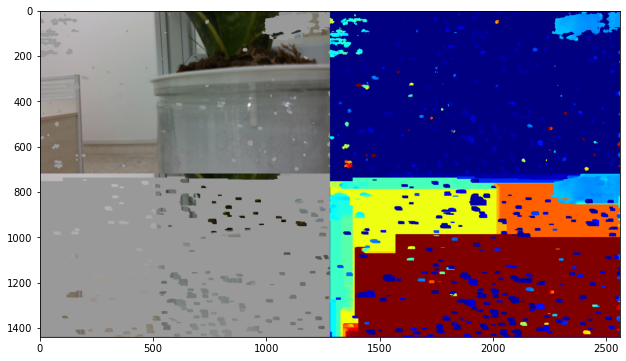

In [124]:
#===独立数据 = 处理环节===#    
depth_scale = 0.0010000000474974513 
clipping_distance_in_meters = 1       #1 meter
clipping_distance = clipping_distance_in_meters / depth_scale

Seq_num = 2
#图像路径
Image_path = ["./Image_NPY/NPY_color_depth/", "./Image_NPY/NPY_Infrared/", "./Image_NPY/NPY_depthFill/", 
            "./Image_IMG/IMG_color_depth/", "./Image_IMG/IMG_Infrared/", "./Image_IMG/IMG_depthFill/"]   

color_image_npy = np.load(file = Image_path[0] +'color_'+ str(Seq_num).zfill(6) +'.npy') 
deep_image_npy = np.load(file = Image_path[0] +'depth_'+ str(Seq_num).zfill(6) +'.npy') 
deep_image_npy_cMAP = cv2.applyColorMap(cv2.convertScaleAbs(deep_image_npy, alpha=0.03), cv2.COLORMAP_JET) 

deep_image_npy_3d = np.dstack((deep_image_npy, deep_image_npy, deep_image_npy)) 
gray_color = np.ones_like(color_image_npy) * 153 
backg_remove = np.where( (deep_image_npy_3d > clipping_distance) | (deep_image_npy_3d < 0) , gray_color , color_image_npy ) 

images = np.hstack((backg_remove, deep_image_npy_cMAP)) 

#深度图像fill
deepFill_image_npy = np.load(file = Image_path[2] +'depthFill_'+ str(Seq_num).zfill(6) +'.npy') 
print(Image_path[2] +'depthFill_'+ str(Seq_num).zfill(6) +'.npy')
deepFill_image_npy_cMAP = cv2.applyColorMap(cv2.convertScaleAbs(deepFill_image_npy, alpha=0.03), cv2.COLORMAP_JET) 

deepFill_image_npy_3d = np.dstack((deepFill_image_npy, deepFill_image_npy, deepFill_image_npy)) 
gray_color = np.ones_like(color_image_npy) * 153 
backg_remove = np.where( (deepFill_image_npy_3d > clipping_distance) | (deepFill_image_npy_3d < 0) , gray_color , color_image_npy ) 

images_Fill = np.hstack((backg_remove, deepFill_image_npy_cMAP)) 

images_T = np.vstack((images, images_Fill)) 


images_plt = cv2.cvtColor(images_T, cv2.COLOR_BGR2RGB) 
plt.rcParams['figure.figsize'] = [16, 6] 
plt.imshow(images_plt) 


In [12]:
#===创建的目录= 函数===#
def mkdir(path):
    import os      # 引入模块
    isExists=os.path.exists(path) # 判断路径是否存在 #存在True  #不存在 False
    if not isExists: # 判断结果
        os.makedirs(path) # 创建目录操作函数
        print (path +' 创建成功')
        return True
    else:  
        print (path+' 目录已存在')# 如果目录存在则不创建，并提示目录已存在
        return False
        
# 定义要创建的目录
Image_path = ["./Image_NPY/NPY_color_depth/", "./Image_NPY/NPY_Infrared/", "./Image_NPY/NPY_depthFill/", 
            "./Image_IMG/IMG_color_depth/", "./Image_IMG/IMG_Infrared/", "./Image_IMG/IMG_depthFill/"]   
# 调用函数
for path in Image_path:
    mkdir(path)



./Image_NPY/NPY_color_depth/ 创建成功
./Image_NPY/NPY_Infrared/ 创建成功
./Image_NPY/NPY_depthFill/ 创建成功
./Image_IMG/IMG_color_depth/ 创建成功
./Image_IMG/IMG_Infrared/ 创建成功
./Image_IMG/IMG_depthFill/ 创建成功


In [126]:
IMG_LIST=[[640,480],[1280,720]]
IMG_LIST[0][0]
IMG_LIST[0][1]

480